## Fonction to Raster
Prend en entrée une Satellite Image, un dossier et un nom et la sauve en JP2 dans le dossier considéré

In [ ]:
! pip install pyarrow -q -q -q 
! pip install rasterio -q -q -q 
! pip install geopandas -q -q -q
! pip install matplotlib -q -q -q
! pip install albumentations -q -q -q
! pip install pytorch_lightning -q -q -q
!pip install mlflow -q -q -q

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')
from utils.satellite_image import SatelliteImage
from utils.utils import *
from utils.plot_utils import *

import yaml
import re
import s3fs
import numpy as np
import matplotlib.pyplot as plt
#import cv2
from PIL import Image as im

from datetime import date
import re
import pyproj
import os
from tqdm import tqdm
from utils.labeler import RILLabeler
from utils.filter import is_too_black

In [12]:
root_path = get_root_path()
root_path

PosixPath('/home/onyxia/work/detection-habitat-spontane/notebooks/..')

In [21]:
update_storage_access()
environment = get_environment()

root_path = get_root_path()
bucket = environment["bucket"]
path_s3_cayenne_data = environment["sources"]["PLEIADES"][2022]["guyane"]
path_local_cayenne_data = os.path.join(root_path, environment["local-path"]["PLEIADES"][2022]["guyane"])

path_s3_pleiades_data_2022_martinique = environment["sources"]["PLEIADES"][2022]["martinique"]
path_local_pleiades_data_2022_martinique = os.path.join(root_path,environment["local-path"]["PLEIADES"][2022]["martinique"])

fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})


In [ ]:
fs.download(
        rpath=f"{bucket}/{path_s3_cayenne_data}",
        lpath=f"{path_local_cayenne_data}",
        recursive=True)

In [22]:
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data_2022_martinique}",
        lpath=f"{path_local_pleiades_data_2022_martinique}",
        recursive=True)

In [ ]:
def to_raster(satellite_image,directory_name,file_name):
    """
    save a SatelliteImage Object into a raster file (.tif)

    Args:
        satellite_image: a SatelliteImage object representing the input image to be saved as a raster file.
        directory_name: a string representing the name of the directory where the output file should be saved.
        file_name: a string representing the name of the output file.
    """

    data = satellite_image.array
    crs  = satellite_image.crs
    transform = satellite_image.transform
    n_bands = satellite_image.n_bands

    metadata = {
        'dtype': data.dtype,
        'count': n_bands,
        'width': data.shape[2],
        'height': data.shape[1],
        'crs': crs,
        'transform': transform
    }
    
    #print(os.path.exists(directory_name))
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)

    # Save the array as a raster file in jp2 format
    with rasterio.open(directory_name + "/" + file_name, 'w', **metadata) as dst:
        dst.write(data, indexes = np.arange(n_bands)+1)


def write_splitted_images_masks(file_path,output_directory_name,labeler,tile_size,n_bands, dep):
    
    """
    write the couple images mask into a specific folder

    Args:
        file_path: a string representing the path to the directory containing the input image files.
        output_directory_name: a string representing the name of the output directory where the split images and masks should be saved.
        labeler: a Labeler object representing the labeler used to create segmentation labels.
        tile_size: an integer representing the size of the tiles to split the input image into.
        n_bands: an integer representing the number of bands in the input image.
        dep: a string representing the department of the input image, or None if not applicable.
    """
    
    output_images_path  = output_directory_name + "/images"
    output_masks_path  = output_directory_name + "/labels"
    
    if not os.path.exists(output_masks_path):
        os.makedirs(output_masks_path)
        
    list_name = os.listdir(file_path)
    list_path = [file_path + "/" + name for name in list_name]
    
    for path, file_name in zip(list_path,tqdm(list_name)): # tqdm ici 

        big_satellite_image = SatelliteImage.from_raster(
            file_path = path,
            dep = None,
            date = None,
            n_bands= 3
        )

        list_satellite_image = big_satellite_image.split(tile_size)
        list_satellite_image = [im for im in list_satellite_image if not is_too_black(im)]
        # mettre le filtre is too black ici !!!
        for i, satellite_image in enumerate(list_satellite_image):
                
                mask = labeler.create_segmentation_label(satellite_image) 
                file_name_i = file_name.split(".")[0]+"_"+str(i)
                if(np.sum(mask) == 0): # je dégage les masques vides j'écris pasd
                    continue
                to_raster(satellite_image,output_images_path,file_name_i + ".tif")
                np.save(output_masks_path+"/"+file_name_i+".npy",mask) # save


### Test sur une image

In [ ]:
satellite_image = SatelliteImage.from_raster(
        file_path = f"{path_local_cayenne_data}"+ "/ORT_2022072050325085_0352_0545_U22N_16Bits.jp2",
        dep = None,
        date = None,
        n_bands= 4)

print(satellite_image.array.shape)
i = 2
directory_name = "../splitted_data"
file_name = "ORT_2022072050325085_0352_0545_U22N_16Bits"+"_"+str(i)+".tif"

to_raster(satellite_image,directory_name,file_name)


## Test sur l'ensemble des images

- je prends un répertoire en entrée Par exemple Guyane et je lis je split et réécris les images en taille 250
- compter le nombre d'images à traiter et le nombre d'images à l'arrivée.
- Si plusieurs années dispo généraliser le labeller 

In [ ]:
filename

In [ ]:

# params 
file_path = f"{path_local_pleiades_data_2022_martinique}"
tile_size = 250
n_bands = 3
dep ="973"
filename = os.listdir(file_path)[0]
date = datetime.strptime(re.search(r'ORT_(\d{8})', filename).group(1), '%Y%m%d') 
labeler = RILLabeler(date, dep = dep, buffer_size = 10) 
output_directory_name = "../splitted_data"

write_splitted_images_masks(file_path,output_directory_name,labeler,tile_size,n_bands,dep)

# 1 min pour 250 -> 4min pour 1000, ça se tente un peu lionguet mais 

AttributeError: 'NoneType' object has no attribute 'group'

In [ ]:
len(os.listdir(output_directory_name+"/labels"))
len(os.listdir(output_directory_name+"/images"))

- a priori si je connais le file path : je connais la date et je connais le labeller => créer labeller en amont ?
- On crée un labeller par date et par territoire concerné 
- On créé les masques et on les sauvegarde

 ### Train un modèle de segmentation Réadaptation de la classe DeeplaV3module pour la rendre agnostique  au dataset etc..

In [25]:
#%load_ext autoreload
#%autoreload 2
#%reload_ext autoreload
import sys
sys.path.append('../src')
import utils.utils
import sys
import os

import pytorch_lightning as pl
import torch
import gc
import albumentations as album
from albumentations.pytorch.transforms import ToTensorV2
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)

## from src
from datas.components.dataset import PleiadeDataset, ChangeDetectionS2LookingDataset
from models.components.segmentation_models import DeepLabv3Module
from models.segmentation_module import SegmentationModule
from datas.datamodule import DataModule


In [ ]:
update_storage_access()
#%env AWS_ACCESS_KEY_ID=projet-slums-sa
#%env AWS_SECRET_ACCESS_KEY=hB2N6hCmp7JoFA6WHKT022WJ9lOc1oOr # chercher ça dans secret ? normalement le update storage access suffit
#%env AWS_S3_ENDPOINT=minio.lab.sspcloud.fr
%env MLFLOW_S3_ENDPOINT_URL=https://minio.lab.sspcloud.fr
# à préciser en +

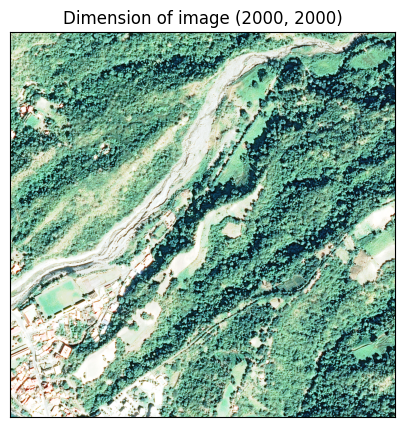

In [7]:
satellite_image = SatelliteImage.from_raster(
        file_path = "../data/PLEIADES/2022/MARTINIQUE/ORT_2022_0691_1638_U20N_8Bits.jp2",
    #"../data/PLEIADES/2020/MAYOTTE/ORT_2020052526670967_0524_8590_U38S_8Bits.jp2", # 255 couleurs..
        dep = None,
        date = None,
        n_bands= 3)
satellite_image.plot([0,1,2])

In [ ]:

## Création Dataset
torch.cuda.empty_cache()
gc.collect()

dir_data = "../splitted_data"
list_path_labels =  np.sort([dir_data + "/labels/" + name for name in os.listdir(dir_data+"/labels")])# os.wlk dans d'autres cas sous des sous arbres de S2Looking
list_path_images =  np.sort([dir_data + "/images/" + name for name in os.listdir(dir_data+"/images")])
dataset = PleiadeDataset(list_path_images,list_path_labels)

# liste d'images test à tester 
satellite_image = SatelliteImage.from_raster(
        file_path =  "../data/PLEIADES/2020/MAYOTTE/ORT_2020052526670967_0524_8590_U38S_8Bits.jp2",
    # "../data/PLEIADES/2022/MARTINIQUE/ORT_2022_0691_1638_U20N_8Bits.jp2",
        dep = None,
        date = None,
        n_bands= 3) # ../data/PLEIADES/2020/MAYOTTE/ORT_2020052526670967_0524_8590_U38S_8Bits.jp2 fonctions d'affichage de Raya

list_test = satellite_image.split(250)
directory_image_name = "../test_data/images/"

for i,simg in enumerate(list_test):
    file_name = simg.filename.split(".")[0] +"_"+str(i)+".tif"
    to_raster(simg,directory_image_name,file_name)

list_path_images_test = np.sort([directory_image_name + filename for filename in os.listdir(directory_image_name)])
list_path_labels_test =   np.sort(list_path_labels[:len(list_path_images_test)])# pas propre je metsd une liste de labels de même taille inutilisés

dataset_test = PleiadeDataset(list_path_images_test,list_path_labels_test) 

# à changer avec des images bien spécifiques et une fonction préparer test
# faire un mini batch qui ne contient que les patchs d'uune image d'intérêt créer les fichiers iages en local et les utiliser pour reconstituer une full image !
# print(list_path_images_test)

## Transforms à mettre dans le data module
image_size = (250,250)
transforms_augmentation = album.Compose(
        [
            album.Resize(300, 300, always_apply=True),
            album.RandomResizedCrop(
                *image_size, scale=(0.7, 1.0), ratio=(0.7, 1)
            ),
            album.HorizontalFlip(),
            album.VerticalFlip(),
            album.Normalize(),
            ToTensorV2(),
       ]
    )

transforms_preprocessing = album.Compose(
        [
            album.Resize(*image_size, always_apply=True),
            album.Normalize(),
            ToTensorV2(),
        ]
)



## Instanciation modèle et paramètres d'entraînement

optimizer = torch.optim.SGD
optimizer_params = {"lr": 0.0001, "momentum": 0.9}
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler_params = {}
scheduler_interval = "epoch"

model = DeepLabv3Module()



##Instanciation des datamodule et plmodule


data_module = DataModule(
    dataset= dataset,
    transforms_augmentation=transforms_augmentation,
    transforms_preprocessing=transforms_preprocessing,
    num_workers=1, 
    batch_size=9,
    dataset_test = dataset_test
)


lightning_module = SegmentationModule(
    model=model,
    optimizer=optimizer,
    optimizer_params=optimizer_params,
    scheduler=scheduler,
    scheduler_params=scheduler_params,
    scheduler_interval=scheduler_interval,
)



checkpoint_callback = ModelCheckpoint(
    monitor="validation_IOU", save_top_k=1, save_last=True, mode="max"
)

early_stop_callback = EarlyStopping(
    monitor="validation_loss", mode="min", patience=3
)
lr_monitor = LearningRateMonitor(logging_interval="step")

strategy ="auto"
list_callbacks = [lr_monitor, checkpoint_callback, early_stop_callback]


In [16]:
#!pip install mlflow
import mlflow
mlflow.end_run()

run_name = "modele deeplabV37"
remote_server_uri = "https://projet-slums-detection-386760.user.lab.sspcloud.fr"
experiment_name = "segmentation"


mlflow.set_tracking_uri(remote_server_uri)
mlflow.set_experiment(experiment_name)
mlflow.pytorch.autolog()



with mlflow.start_run(run_name=run_name):

    trainer = pl.Trainer(
    callbacks= list_callbacks,
    max_epochs=100,
    num_sanity_val_steps=2,
    strategy=strategy,
    log_every_n_steps=2
    )
    trainer.fit(lightning_module, datamodule=data_module)


2023/04/14 23:20:15 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023/04/14 23:20:15 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/mamba/lib/python3.10/site-packages/mlflow/pytorch/_lightning_autolog.py:352: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 1.0.5 and 1.9.3 and may not succeed with packages outside this range."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-----

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

KeyboardInterrupt: 

## Test du modèle

In [20]:
#trainer.checkpoint_callback.best_model_path
import mlflow
mlflow.end_run()

run_name = "modele deeplabV35"
remote_server_uri = "https://projet-slums-detection-386760.user.lab.sspcloud.fr"
experiment_name = "segmentation"

mlflow.set_tracking_uri(remote_server_uri)
mlflow.set_experiment(experiment_name)
mlflow.pytorch.autolog()

output_ligthning = '~/work/detection-habitat-spontane/notebooks/lightning_logs/'

with mlflow.start_run(run_id="f0ae3db014404b98863792fbdb48a289"):
    model = DeepLabv3Module()
    
    lightning_module_checkpoint = lightning_module.load_from_checkpoint(
    checkpoint_path=trainer.checkpoint_callback.best_model_path,
    #checkpoint_path=output_ligthning+'version_O/checkpoints/last.ckpt',
    model= model,
    optimizer=optimizer,
    optimizer_params=optimizer_params,
    scheduler=scheduler,
    scheduler_params=scheduler_params,
    scheduler_interval=scheduler_interval
                                         )
    artifact_path = "modele_segmentation_deeplabv3"
    mlflow.pytorch.log_model(lightning_module_checkpoint.model, artifact_path)

    trainer = pl.Trainer(
    callbacks= list_callbacks,
    max_epochs=50,
    num_sanity_val_steps=2,
    strategy=strategy,
    log_every_n_steps=2
    )
    trainer.test(lightning_module_checkpoint, datamodule=data_module)


2023/04/14 23:23:16 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
2023/04/14 23:23:28 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpzm_gtx46/model/data, flavor: pytorch), fall back to return ['torch==2.0.0', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
/opt/mamba/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2023/04/14 23:23:32 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under s3://projet-slums-detection/mlflow-artifacts/1/f0ae3db014404b98863792fbdb48a289/artifacts. In addi

Testing: 0it [00:00, ?it/s]

RasterioIOError: Caught RasterioIOError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "rasterio/_io.pyx", line 938, in rasterio._io.DatasetReaderBase._read
  File "rasterio/_io.pyx", line 176, in rasterio._io.io_multi_band
  File "rasterio/_err.pyx", line 195, in rasterio._err.exc_wrap_int
rasterio._err.CPLE_AppDefinedError: ../test_data/images/ORT_2022_0691_1638_U20N_8Bits_0.tif, band 1: IReadBlock failed at X offset 0, Y offset 23: TIFFReadEncodedStrip() failed.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/mamba/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/mamba/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/mamba/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/onyxia/work/detection-habitat-spontane/notebooks/../src/datas/components/dataset.py", line 193, in __getitem__
    img = SatelliteImage.from_raster(
  File "/home/onyxia/work/detection-habitat-spontane/notebooks/../src/utils/satellite_image.py", line 182, in from_raster
    array = raster.read(
  File "rasterio/_io.pyx", line 614, in rasterio._io.DatasetReaderBase.read
  File "rasterio/_io.pyx", line 941, in rasterio._io.DatasetReaderBase._read
rasterio.errors.RasterioIOError: Read or write failed. ../test_data/images/ORT_2022_0691_1638_U20N_8Bits_0.tif, band 1: IReadBlock failed at X offset 0, Y offset 23: TIFFReadEncodedStrip() failed.


# faire une fonction !!
- Ici j'évalue un batch à la mano

In [ ]:

def evaluate_quick(datasetparam,model,idx):
    imagesat = SatelliteImage.from_raster(datasetparam.list_paths_images[idx],"976",n_bands = 3) 

    model.eval()
    model = model.to("cuda")
    #image, mask, dic = dataset_test[idx]
    image, mask, dic = datasetparam[idx]

    # mask réel
    plt.imshow(mask, cmap='binary', interpolation='none')
    plt.colorbar(ticks=[0, 1])
    plt.show()

    # image
    imagesat.plot([0,1,2])

    # model
    output = model(image.unsqueeze(0).to("cuda"))
    print(output.shape)
    mask_model = np.array(torch.argmax(output,axis= 1).squeeze(0).to("cpu"))
    print(np.sum(mask_model))
    # mask model
    plt.imshow(mask_model, cmap='binary', interpolation='none')
    plt.colorbar(ticks=[0, 1])
    plt.show()


In [ ]:
mask_model

In [ ]:

model = lightning_module_checkpoint.model
#evaluate_quick(dataset,model,23)
evaluate_quick(dataset,model,70)
evaluate_quick(dataset_test,model,49)

- marrant de voir comment la normalisation detecte les logements..sérendipité
- qgis

## PEtite enquête pour savoir pourquoi les résultats sont éclatés sur l'exmple de MAyotte

In [ ]:
idx = 2

for idx in range(64):
    imagesat = SatelliteImage.from_raster(dataset_test.list_paths_images[idx],"976",n_bands = 3) 
    print(torch.max(dataset_test[idx][0]))
    np.max(imagesat.array)
    
for idx in range(64):
    imagesat = SatelliteImage.from_raster(dataset.list_paths_images[idx],"976",n_bands = 3) 
    print(torch.max(dataset[idx][0]))
    np.max(imagesat.array)
np.max(satellite_image.array)

Il y a déjà une normalisation entre 0 et 255 appliqué&e sur mayotte ça peut forcément pas marcher..

### Test du modèle

TO DO :
- les images Guyane sont en 16 bits et MAyotte et martinique etc.. en 8 normal que ça deconne
- faire en sorte de calculer plusieurs grosse images sur le .test et trouver une autre image que mayotte pour le moment qui est en 255 couleurs... != du reste
- mettre une oimage de la validation en jeu
- mettre le calcul d'image dans la validation aussi ?
- mettre dans data set test une image du jeu de validatio à minima et une image de jeu externe etc..
- dégager aussi les RIL vides ? Oui
- labelstudio, segment anything model
- bien construire un beau jeu de test avec cet outil  label studio, labellisation à la main , pour evaluation pertinente !!
- mettre le [0,1,2] par défautdans les plots
- se servir du if batch idx == 10 recharger tout les fichiers des batchs précédents et en faire une satellite data, stocker également ce qui fera une seule image et donc une seule labelled satellite image ..
- dans le filename des images splittée changer avec les bonnes coordonnées dans lenom (trouvable dans la bounding box..)
- faire une fonction générer dataset test qui servira pour tous les tests
- test de lancement via invit de comande train
- généraliser la création de liste de file path selon le dataset souhaité
- créer un yaml de config et le logger dans mlflow
- contrîole sur le modèle qui est loggé dans ml flow ?
- resoudre le bug sur l'ambiguité du nombre d'elemeents dans le batch
- workshop fevrier

Reunion section
- 13 travaux
- Production de masques : Juin Juillet,
    - Esane normal + Branches
    - demographie  # RDV Nathanael + soutien code
    - maj EAP (Optionnel)
    - IPI ICA
    - Antipol, tab multi
    
rtauargus prez , veux-tu présenter ? nathanael ?
fideli ..
pour rtauargus mix des différentes présentations déjà faites :
que veux-on partager, pas NTTIS
différentes prez du worksho en Septembre dernier exemples bien senti

Présentation "paillettes" -> d'où vient la complexité des données ? décrire avec le graph
tau argus outil de référence, différnets types de complexité , une partie résolu liens tableaux, partie non résolue, partie analyse de la demande, + méta données non automatisées
-> rtauargus
-> 
-> création liste de tables c'est sympa ça demande une généralisation, une métadonnées nickel permettrait d'automatiser cette analyse
-> insee.fr exemple, overlezf, reprise présentation

- census bureau litterature reunion Julien

## S2Looking training !

dl

In [ ]:
update_storage_access()
environment = get_environment()
root_path = get_root_path()
bucket = environment["bucket"]
path_s3_s2looking = environment["sources"]["PAPERS"]["S2Looking"]
path_local_s2looking = environment["local-path"]["PAPERS"]

fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

fs.download(
        rpath=f"{bucket}/{path_s3_s2looking}",
        lpath=f"../{path_local_s2looking}",
        recursive=True)

In [ ]:
import zipfile
with zipfile.ZipFile(f"../{path_local_s2looking}/S2Looking.zip", 'r') as zip_ref:
    zip_ref.extractall(f"../{path_local_s2looking}")

In [ ]:
#!pip install mlflow
import mlflow

run_name = "s2looking" # config
remote_server_uri = "https://projet-slums-detection-2439.user.lab.sspcloud.fr"
experiment_name = "segmentation" # config

mlflow.set_tracking_uri(remote_server_uri)
mlflow.set_experiment(experiment_name)
# mlflow.pytorch.autolog() # logger la config


## Création Dataset
torch.cuda.empty_cache()
gc.collect()

## En faire une fonction ? : Idée faire une classe de préparation des données pour chaque data set chargé qui in fine sortirait une list path ?

### config, appeler une fionction de création de dataset ?
dir_data = "../data/paper_dataset/S2Looking/"
img1_train = [dir_data + "train/Image1/"+name for name in os.listdir(dir_data + "/train/Image1")]
img1_val = [dir_data + "train/Image1/"+name for name in os.listdir(dir_data + "/train/Image1")]

img1_train = [dir_data + "train/Image1/"+name for name in os.listdir(dir_data + "/train/Image1")]
img1_val = [dir_data + "val/Image1/"+name for name in os.listdir(dir_data + "/val/Image1")]
img1_test = [dir_data + "test/Image1/"+name for name in os.listdir(dir_data + "/test/Image1")]

img2_train = [dir_data + "train/Image2/"+name for name in os.listdir(dir_data + "/train/Image2")]
img2_val = [dir_data + "val/Image2/"+name for name in os.listdir(dir_data + "/val/Image2")]
img2_test = [dir_data + "test/Image2/"+name for name in os.listdir(dir_data + "/test/Image2")]

label_train = [dir_data + "train/label/"+name for name in os.listdir(dir_data + "/train/label")]
label_val = [dir_data + "val/label/"+name for name in os.listdir(dir_data + "/val/label")]
label_test = [dir_data + "test/label/"+name for name in os.listdir(dir_data + "/test/label")]

img1_path = np.concatenate([np.sort(img1_train),np.sort(img1_val),np.sort(img1_test)])
img2_path = np.concatenate([np.sort(img2_train),np.sort(img2_val),np.sort(img2_test)])
label_path = np.concatenate([np.sort(label_train),np.sort(label_val),np.sort(label_test)])

mono_image_dataset = ChangeDetectionS2LookingDataset(img1_path,img2_path,label_path)

# transforms incorporé dans les dataset a posteriori
image_size = (256,256) # cf la classe dataset
transforms_augmentation = album.Compose(
        [
            album.Resize(300, 300, always_apply=True),
            album.RandomResizedCrop(
                *image_size, scale=(0.7, 1.0), ratio=(0.7, 1)
            ),
            album.HorizontalFlip(),
            album.VerticalFlip(),
            album.Normalize(),
            ToTensorV2(),
       ]
    )

transforms_preprocessing = album.Compose(
        [
            album.Resize(*image_size, always_apply=True),
            album.Normalize(),
            ToTensorV2(),
        ]
)


## Instanciation modèle et paramètres d'entraînement

optimizer = torch.optim.SGD
optimizer_params = {"lr": 0.0001, "momentum": 0.9}
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler_params = {}
scheduler_interval = "epoch"

model = DeepLabv3Module(nchannel = 6) # viens du data set qui concatene 2 images à 3 channels

##Instanciation des datamodule et plmodule

data_module = DataModule(
    mono_image_dataset= mono_image_dataset,
    transforms_augmentation=transforms_augmentation,
    transforms_preprocessing=transforms_preprocessing,
    num_workers=1, 
    batch_size=2
)


lightning_module = SegmentationModule(
    model=model,
    optimizer=optimizer,
    optimizer_params=optimizer_params,
    scheduler=scheduler,
    scheduler_params=scheduler_params,
    scheduler_interval=scheduler_interval,
)

checkpoint_callback = ModelCheckpoint(
    monitor="validation_loss", save_top_k=1, save_last=True, mode="min"
)

checkpoint_callback_2 = ModelCheckpoint(
    monitor="train_loss", save_top_k=1, save_last=True, mode="min"
)
early_stop_callback = EarlyStopping(
    monitor="validation_loss", mode="min", patience=3
)
lr_monitor = LearningRateMonitor(logging_interval="step")

strategy ="auto"

with mlflow.start_run(run_name=run_name):

    trainer = pl.Trainer(
    callbacks=[lr_monitor, checkpoint_callback,checkpoint_callback_2, early_stop_callback],
    max_epochs=100,
    num_sanity_val_steps=2,
    strategy=strategy,
    log_every_n_steps=2
    )
    trainer.fit(lightning_module, datamodule=data_module)
    
    lightning_module_checkpoint = lightning_module.load_from_checkpoint(
    checkpoint_path=trainer.checkpoint_callback.best_model_path
    model=model,
    optimizer=optimizer,
    optimizer_params=optimizer_params,
    scheduler=scheduler,
    scheduler_params=scheduler_params,
    scheduler_interval=scheduler_interval
                                     )
    artifact_path = "models/modele_change_detection_deeplabv3_on_s2_looking"
    mlflow.pytorch.log_model(lightning_module_checkpoint.model, artifact_path)
    
    